In [1]:
%pylab inline
from libanalysis import PhantomAnalysis as pa
from scipy.signal import savgol_filter

from scipy import signal
from scipy.signal import find_peaks

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_acc_particle(dump, R):
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    
    r = np.sqrt(x**2 + y**2 + z**2)
    return r <= R

def inter_ep(dump):
    m = dump.massofgas
    
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    
    ep = np.zeros(x.shape)

    for xx, yy, zz, i in zip(x, y, z, range(len(x))):
        dx = x - xx
        dy = y - yy
        dz = z - zz
        dr = np.sqrt(dx**2 + dy**2 + dz**2)
        p = (1/dr[dr!=0]).sum()
        ep[i] = -p*m
        
    return ep

def get_E(dump, Mb):
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    ep = -Mb/r #+ inter_ep(dump)
    
    vx = dump.vxyz[0]
    vy = dump.vxyz[1]
    vz = dump.vxyz[2]
    
    ek = 0.5*(vx**2 + vy**2 + vz**2)
    
    return ep+ek

def get_ecc(dump, Mb):
    
    u = Mb
    
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    vx = dump.vxyz[0]
    vy = dump.vxyz[1]
    vz = dump.vxyz[2]
    
    v2 = np.sqrt(vx**2 + vy**2 + vz**2)
    
    dot = x*vx + y*vy + z*vz
    
    rcof = v2/u - 1/r
    
    vcof = dot/u
    
    ex = rcof * x - vcof * vx
    
    ey = rcof * y - vcof * vy
    
    ez = rcof * z - vcof * vz
    
    e = np.sqrt(ex**2 + ey**2 + ez**2)
    
    return e

def get_bound(dump, Mb):
    return get_E(dump, Mb) < 0

def get_e_disk_particle(dump, Mb):
    e = get_ecc(dump, Mb)
    
    t = dump.time
    
    xbins = 'auto'

    
    num, bins = np.histogram(e,bins=xbins,density=True)

    cbin = 0.5*(bins[0:-1] + bins[1::])
    
    zero = np.argmin(num)
    
    valley_idx = signal.argrelextrema(num, np.less, order=2)
    valley_idx = valley_idx[0]

    peaks, _ = find_peaks(num, prominence=0.25)
    
    disjoint = 0
    #if ((t>200)&len(peaks) <= 1):
    #    disjoint = -1
    if( (len(peaks)>1)):
        peak1 = peaks[0]
        peak2 = peaks[1]
    
        if (peak1 < zero) & (zero < peak2):
            disjoint = zero
        elif len(valley_idx) > 0:
            for v in valley_idx:
                if (peak1 < v)&(v < peak2)&(v>disjoint):
                    disjoint = v
        
    
    if disjoint == 0:
        if(t > 150):
            critical_e = cbin[   valley_idx[peaks[0] < valley_idx][0] ]
        else:
            critical_e = 0
    else:
        critical_e = cbin[disjoint]
    
    return (e < critical_e) & (e>0) &(e<1)

def get_disk_particle(dump, Mb):
    E = get_E(dump, 10)
    a = -10/2/E
    
    t = dump.time
    
    xbins = 'auto'
    
    amin = 0.5
    amax = 1000
    
    num, bins = np.histogram(np.log10(a[(amin<a)&(a<amax)]),bins=xbins,density=True)

    cbin = 0.5*(bins[0:-1] + bins[1::])
    
    zero = np.argmin(num)
    
    valley_idx = signal.argrelextrema(num, np.less, order=2)
    valley_idx = valley_idx[0]

    peaks, _ = find_peaks(num, prominence=0.25)
    
    disjoint = 0
    #if ((t>200)&len(peaks) <= 1):
    #    disjoint = -1
    if( (len(peaks)>1)):
        peak1 = peaks[0]
        peak2 = peaks[1]
    
        if (peak1 < zero) & (zero < peak2):
            disjoint = zero
        elif len(valley_idx) > 0:
            for v in valley_idx:
                if (peak1 < v)&(v < peak2)&(v>disjoint):
                    disjoint = v
        
    if t > 500:
        critical_a = 1000
        
    elif disjoint == 0:
        if(t > 150):
            critical_a = 10**cbin[   valley_idx[peaks[0] < valley_idx][0] ]
        else:
            critical_a = 0
    else:
        critical_a = 10**cbin[disjoint]
    
    return (a < critical_a) & (a>0)

def get_fall_particle(dump, Mb, R):
    return get_disk_particle(dump, Mb) | get_acc_particle(dump, R)
    
def draw(dump, idx):
    plt.figure()
    plt.scatter(dump.xyzh[0][idx], dump.xyzh[1][idx],s=0.001)
    plt.scatter(dump.xyzh[0][~idx], dump.xyzh[1][~idx],s=0.001)

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
Unable to load uterm, likely the quantity is not stored.
Unable to loa

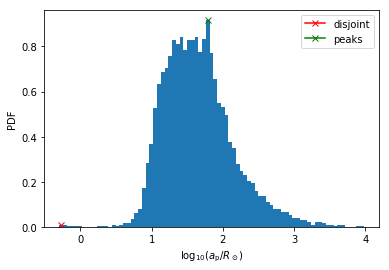

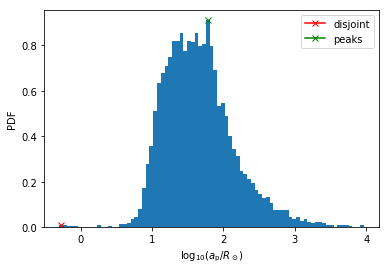

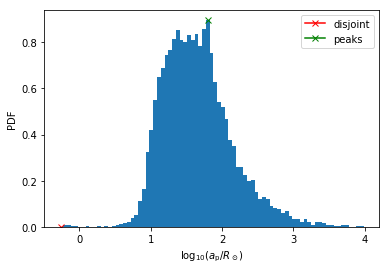

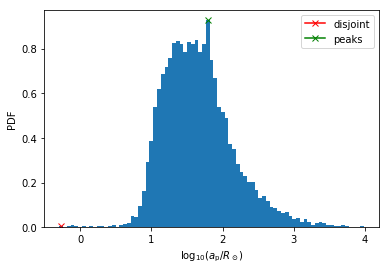

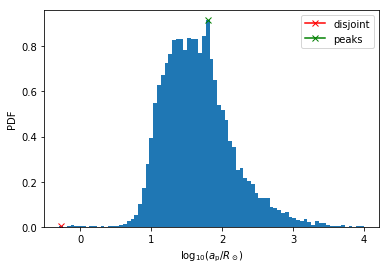

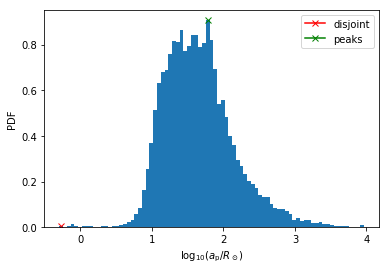

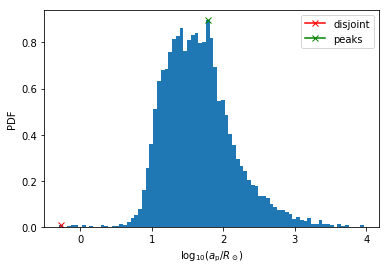

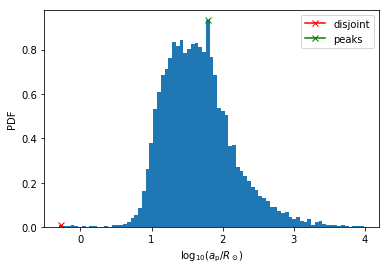

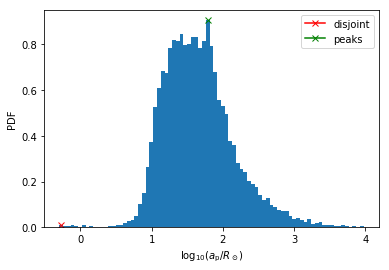

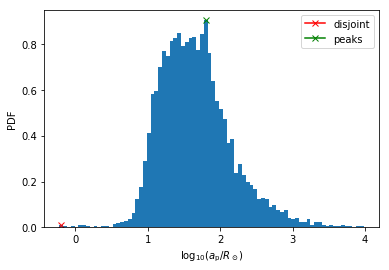

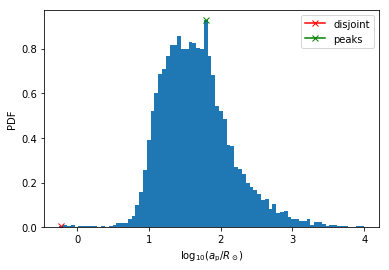

In [3]:
def draw_a(dump, Mb, figname):
    a = -Mb/2/get_E(dump, Mb)
    xbins = 'auto'
    
    amin = 0.5
    amax = 10000
    
    t = dump.time
    
    num, bins = np.histogram(np.log10(a[(amin<a)&(a<amax)]),bins=xbins,density=True)
    
    plt.figure()
    plt.hist(np.log10(a[(amin<a)&(a<amax)]),bins=xbins,density=True)

    cbin = 0.5*(bins[0:-1] + bins[1::])
    
    zero = np.argmin(num)
    
    valley_idx = signal.argrelextrema(num, np.less, order=2)
    valley_idx = valley_idx[0]

    peaks, _ = find_peaks(num, prominence=0.25)
    
    disjoint = 0
    #if ((t>200)&len(peaks) <= 1):
    #    disjoint = -1
    if( (len(peaks)>1)):
        peak1 = peaks[0]
        peak2 = peaks[1]
    
        if (peak1 < zero) & (zero < peak2):
            disjoint = zero
        elif len(valley_idx) > 0:
            for v in valley_idx:
                if (peak1 < v)&(v < peak2)&(v>disjoint):
                    disjoint = v
        
    
    if disjoint == 0:
        if(t > 150):
            
            critical_a = 10**cbin[   valley_idx[peaks[0] < valley_idx][0] ]
        else:
            critical_a = 0
    else:
        critical_a = 10**cbin[disjoint]
                    
    plt.plot(cbin[disjoint], num[disjoint],color='r',marker='x',label='disjoint')
    plt.plot(cbin[peaks], num[peaks],color='g',marker='x',label='peaks')
    plt.legend()
    plt.xlabel('$\log_{10}(a_{\\rm p}/R_\odot)$')
    plt.ylabel('PDF')
    plt.savefig(figname,dpi=192)
    
    
prefix = '../code/heating-huge//'
idx = np.linspace(800,810,11)

for i in idx:
    fname = 'tde_%05d'% i
    dump = pa(prefix+fname)
    draw_a(dump, 10,'figs/dist_a_%05d.png' % (i/10))

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.


IOError: [Errno 2] No such file or directory: 'figs/classify_00000.png'

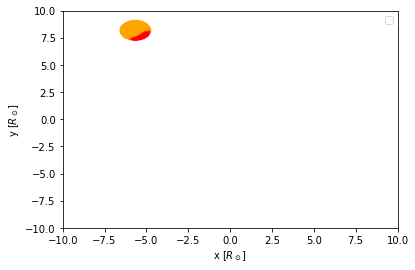

In [34]:
colors = cm.viridis(np.linspace(0,1,3))
def draw_classify(dump, Mb, figname):
    disk = get_disk_particle(dump, 10)
    acc = get_acc_particle(dump, 4.2e-3)
    rem = (~acc) & (~disk)
  
    plt.figure()
    plt.scatter(dump.xyzh[0][rem], dump.xyzh[1][rem],s=0.01,color='orange')
    
    plt.scatter(dump.xyzh[0][disk], dump.xyzh[1][disk],s=0.01,color='red')
    
    plt.scatter(dump.xyzh[0][acc], dump.xyzh[1][acc],s=0.001,color='k')
    
    plt.legend()
    plt.xlabel('x [$R_\odot$]')
    plt.ylabel('y [$R_\odot$]')
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.savefig(figname,dpi=192)
    
    
prefix = '../code/low_N/rp1/'
idx = np.linspace(0,1140,115)

for i in idx:
    fname = 'tde_%05d'% i
    dump = pa(prefix+fname)
    draw_classify(dump, 10,'figs/classify_%05d.png' % (i/10))

In [22]:
dump = pa('../code/low_N/rp09/tde_00080')
print(dump.units['utime'])
#ecc=get_ecc(dump, 10)
#plt.figure()
#plt.hist(ecc[ecc<1],bins='auto',histtype='step',density=True)

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
1593.7103639


In [4]:
def get_masses(prefix, idx):
    times =[]
    disk_m=[]
    acc_m =[]
    for i in idx:
        fname = 'tde_%05d'% i
        print(fname)
        dump = pa(prefix+fname)
        times.append(dump.time * dump.units['utime'])
        disk_m.append(dump.massofgas * (get_disk_particle(dump, 10)).sum())
        acc_m.append(dump.massofgas * (get_acc_particle(dump, 4.2e-3)).sum())
   

    times = np.array(times)
    disk_m = np.array(disk_m)
    acc_m = np.array(acc_m)
    return times, disk_m, acc_m



In [ ]:
#times_h, disk_m_h, acc_m_h = get_masses('../code/low_N/rp1-heating/', np.linspace(0,108,55))

times_1, disk_m_1, acc_m_1 = get_masses('../code/low_N/rp1/', np.linspace(0,2720,273))

times_09, disk_m_09, acc_m_09 = get_masses('../code/low_N/rp09/', np.linspace(0,1220,123))

times_06, disk_m_06, acc_m_06 = get_masses('../code/low_N/rp06/', np.linspace(0,1250,126))

times =[times_1, times_09, times_06]
disk_m = [disk_m_1, disk_m_09, disk_m_06]
acc_m = [acc_m_1, acc_m_09, acc_m_06]

colors = ['g','orange','r']
labels = ['$r_{\\rm p}=r_{\\rm t}$', '$r_{\\rm p}=0.9r_{\\rm t}$', '$r_{\\rm p}=0.6r_{\\rm t}$']

In [32]:
time_iso, disk_iso, acc_iso =get_masses('../code/low_N/rp1/', np.linspace(0,2720,273))

time_adi, disk_adi, acc_adi =get_masses('../code/new-without-heating/', np.linspace(0,178,179))


times =[time_iso, time_adi]
disk_m = [disk_iso, disk_adi]
acc_m = [acc_iso, acc_adi]

colors = ['g','orange']
labels = ['fake isothermal with $\Gamma=5/3$', 'adiabatic with $\Gamma=5/3$']

tde_00000
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00010
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00020
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00030
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00040
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00050
Unable to 

KeyboardInterrupt: 

In [39]:
time_low, disk_low, acc_low =get_masses('../code/heating-huge/', np.linspace(0,1000,1001))
time_high, disk_high, acc_high =get_masses('../code/high_N/huge/', np.linspace(0,988,989))


times =[time_low, time_high]
disk_m = [disk_low, disk_high]
acc_m = [acc_low, acc_high]



tde_00000
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00001
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00002
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00003
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00004
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00005
Unable to 

tde_00045
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00046
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00047
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00048
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00049
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00050
Unable to 

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00092
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00093
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00094
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00095
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00096
Unable to load uterm

tde_00133
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00134
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00135
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00136
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00137
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00138
Unable to 

tde_00182
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00183
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00184
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00185
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00186
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00187
Unable to 

tde_00236
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00237
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00238
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00239
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00240
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00241
Unable to 

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00288
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00289
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00290
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00291
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00292
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00341
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00342
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00343
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00344
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00345
Unable to load uterm

tde_00394
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00395
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00396
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00397
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00398
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00399
Unable to 

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00449
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00450
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00451
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00452
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00453
Unable to load uterm

tde_00502
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00503
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00504
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00505
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00506
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00507
Unable to 

tde_00557
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00558
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00559
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00560
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00561
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00562
Unable to 

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00612
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00613
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00614
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00615
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00616
Unable to load uterm

tde_00666
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00667
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00668
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00669
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00670
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00671
Unable to 

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00716
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00717
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00718
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00719
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00720
Unable to load uterm

tde_00764
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00765
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00766
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00767
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00768
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00769
Unable to 

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00808
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00809
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00810
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00811
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00812
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00861
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00862
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00863
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00864
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00865
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00915
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00916
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00917
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00918
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00919
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00968
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00969
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00970
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00971
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00972
Unable to load uterm

tde_00009
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00010
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00011
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00012
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00013
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00014
Unable to 

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00054
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00055
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00056
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00057
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00058
Unable to load uterm

tde_00095
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00096
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00097
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00098
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00099
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00100
Unable to 

tde_00138
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00139
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00140
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00141
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00142
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00143
Unable to 

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00181
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00182
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00183
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00184
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00185
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00224
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00225
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00226
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00227
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00228
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00266
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00267
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00268
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00269
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00270
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00308
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00309
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00310
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00311
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00312
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00350
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00351
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00352
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00353
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00354
Unable to load uterm

tde_00393
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00394
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00395
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00396
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00397
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00398
Unable to 

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00438
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00439
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00440
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00441
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00442
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00480
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00481
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00482
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00483
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00484
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00522
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00523
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00524
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00525
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00526
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00564
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00565
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00566
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00567
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00568
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00606
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00607
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00608
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00609
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00610
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00648
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00649
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00650
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00651
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00652
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00690
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00691
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00692
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00693
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00694
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00732
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00733
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00734
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00735
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00736
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00774
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00775
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00776
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00777
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00778
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00816
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00817
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00818
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00819
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00820
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00858
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00859
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00860
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00861
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00862
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00900
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00901
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00902
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00903
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00904
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00942
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00943
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00944
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00945
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00946
Unable to load uterm

Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00984
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00985
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00986
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00987
Unable to load uterm, likely the quantity is not stored.
Unable to load temperature, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
tde_00988
Unable to load uterm

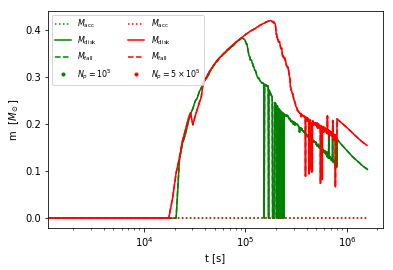

In [46]:
colors = ['g','r']
labels = ['$N_p=10^5$', '$N_p=5\\times 10^5$']

plt.figure()
for c, t, d, a, l in zip(colors, times, disk_m, acc_m, labels):
    plt.plot(t, a,ls=':', label='$M_{\\rm acc}$', color=c)
    plt.plot(t, d,ls='-', label='$M_{\\rm disk}$', color=c)
    plt.plot(t, a+d,ls='--',label='$M_{\\rm fall}$', color=c)
    plt.plot([],[],'.',label=l,color=c)
plt.xscale('log')
plt.legend(ncol=2,fontsize=8)
plt.xlabel('t [s]')
plt.ylabel('m  [$M_\odot$]')
plt.savefig('resolution-accumulated.png',dpi=192)

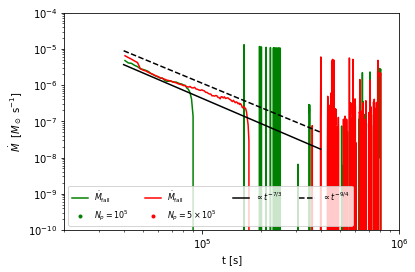

In [47]:
def diff(x, y, step):
    dx = x[1] - x[0]
    return 0.5*(x[step::] + x[0:-step]), savgol_filter((y[step::] - y[0:-step])/(dx*step), 13, 1)
    #return 0.5*(x[step::] + x[0:-step]), (y[step::] - y[0:-step])/(dx*step)
    


ct = 4e4

steps =[1,1,12,1]
plt.figure()
for c, t, d, a, l, step  in zip(colors, times, disk_m, acc_m, labels, steps):
    #dt, da = diff(t, a, step)
    #plt.plot(dt, da, ls=':', label='$\dot{M}_{\\rm acc}$', color=c)
    #dt, dd = diff(t, d, step)
    #plt.plot(dt[dt>ct], dd[dt>ct], ls='--', label='$\dot{M}_{\\rm disk}$', color=c)
    dt, df = diff(t, a+d, step)
    plt.plot(dt[dt>ct], df[dt>ct], ls='-',label='$\dot{M}_{\\rm fall}$', color=c)
    plt.plot([],[],'.',label=l,color=c)
    
time = np.linspace(ct, 4e5)
power1 = 2e5*time**(-7.0/3)
power2 = 2e5*time**(-9.0/4)
plt.plot(time, power1, color='k',ls='-', label='$\propto t^{-7/3}$')
plt.plot(time, power2, color='k',ls='--', label='$\propto t^{-9/4}$')

plt.xscale('log')
plt.yscale('log')
plt.legend(ncol=4,fontsize=8)
plt.xlabel('t [s]')
plt.xlim(2e4, 1e6)
plt.ylim([1e-10,1e-4])
plt.ylabel('$\dot{M}$  [$M_\odot$ s$^{-1}$]')
plt.savefig('resoltion_m_dot.png',dpi=192)

In [186]:
import pandas as pd

def load_ev(name):
    data = np.loadtxt(name)

    t = data[:,0] * 1593.7103639
    ek = data[:,1]
    etherm = data[:,2]
    epot =data[:,4]
    etot =data[:,5]
    eacc =data[:,21]
    totmom=data[:,6]
    angtot=data[:,7]
    totentrop=data[:,11]
    accm = data[:,20]
    return {'t':t, 'ek':ek, 'eth':etherm, 'epot':epot, 'etot':etot, 'eacc':eacc, 'totentrop':totentrop,'macc':accm}
    
#rp1 = load_ev('../code/low_N/rp1/tde.ev')

#rp09 = load_ev('../code/low_N/rp09/tde.ev')
#rp06 = load_ev('../code/low_N/rp06/tde.ev')
#rph = load_ev('../code/heating-cluster/tde.ev')
#plt.plot(t, etherm)

In [10]:
#ev = [rp1, rp09, rp06, rph]
labels = ['rp=1rt', 'rp=09rt', 'rp=06rt', 'rp=1rt with heating']


In [17]:
larger =load_ev('../code/heating-larger/tde01.ev')
small =load_ev('../code/heating-cluster/tde.ev')
labels = ['$R_{acc}=100R_s$', '$R_{acc}=1000R_s$']
ev = [small, larger]

In [22]:
without =load_ev('../code/new-without-heating/tde.ev')
noacc =load_ev('../code/no-acc/tde.ev')
labels = ['without heating', '$No accretion$']
ev = [without, noacc]

In [189]:
larger =load_ev('../code/high_N/huge/tde.ev')
small =load_ev('../code/1M/tde.ev')
labels = ['N=$5\\times 10^5$', 'N=$10^6$']
ev = [small, larger]

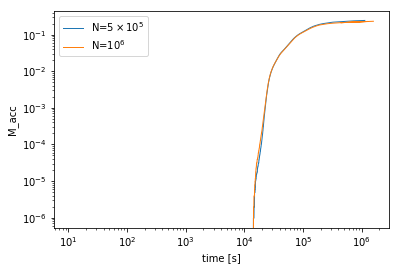

In [190]:
def draw_macc(ev):
    for e, l in zip(ev,labels):
        plt.plot(e['t'],e['macc'],label=l,lw=1)
    plt.legend()
    plt.xlabel('time [s]')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('M_acc')
draw_macc(ev)

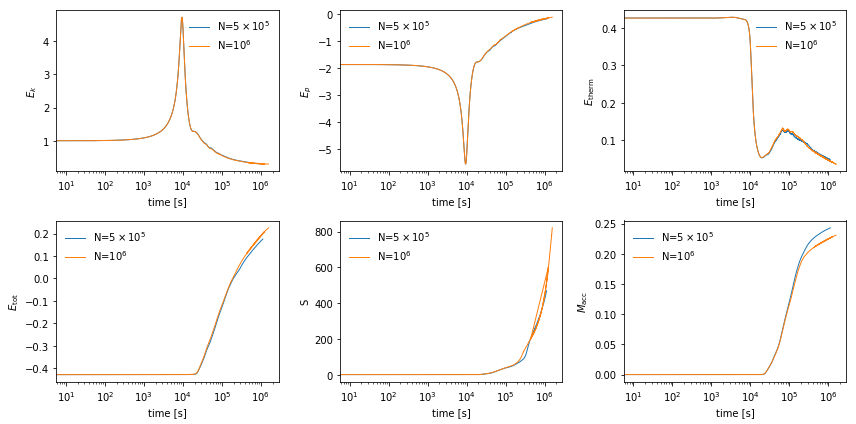

In [191]:
def draw_energy(ev):
    fig = plt.figure(figsize=(12,6))
    
    axs = [ fig.add_subplot(2,3,i+1) for i in range(6)]
    
    for e, l in zip(ev,labels):
        axs[0].plot(e['t'],e['ek'],label=l,lw=1)
        axs[1].plot(e['t'],e['epot'],label=l,lw=1)
        axs[2].plot(e['t'],e['eth'],label=l,lw=1)
        axs[3].plot(e['t'],e['etot'],label=l,lw=1)
        axs[4].plot(e['t'],e['totentrop'],label=l,lw=1)
        axs[5].plot(e['t'],e['macc'],label=l,lw=1)
        
        
    for ax in axs:
        ax.set_xlabel('time [s]')
        ax.set_xscale('log')
        ax.legend(frameon=False)
        
    ylabel = ['$E_k$', '$E_p$', '$E_{\\rm therm}$', '$E_{\\rm tot}$', 'S', '$M_{\\rm acc}$']
    
    for ax, l in zip(axs, ylabel):
        ax.set_ylabel(l)
    plt.tight_layout()
    
    plt.savefig('energies.png',dpi=96)
draw_energy(ev)

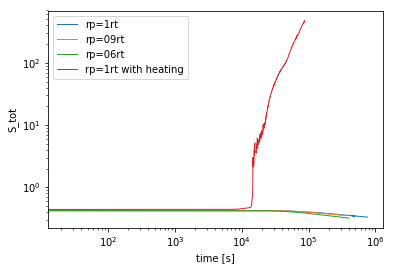

In [41]:
def draw_entropy(ev):
    for e, l in zip(ev,labels):
        plt.plot(e['t'],e['totentrop'],label=l,lw=11)
    plt.legend()
    plt.xlabel('time [s]')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('S_tot')
draw_entropy(ev)

In [2]:
import scipy.stats as st
import matplotlib.mlab as ml
    
def np_array2dic(array, keys, units):
    dic = {}
    for i, key in enumerate(keys):
        dic[key] = array[:,i] * units[i]
        
    return dic 

def load_ascii(fname):
    dic = {}
    data = np.loadtxt(fname)
    keys = ['x','y','z','pmass','h','den','vx','vy','vz','u','T','alpha','div','poten','type']
    units = [9.9992818E-01,   9.9992818E-01,   9.9992818E-01,   1.9890999E+33,   9.9992818E-01,   5.9009576E+00,   4.3668536E+07,   4.3668536E+07,   4.3668536E+07,   1.9069412E+15,  1, 1.0000000E+00,   6.2746659E-04,   1.9069412E+15,1]
    dic = np_array2dic(data, keys, units )
    
    calc_TP(dic)
    return dic

def calc_TP(dump):
    mH = 1.6733e-24
    mean_mole = 2.381 
    kb = 1.38064852e-16
    Gamma = 5.0/3
    T = dump['T'] #dump['u']*(Gamma - 1)* mean_mole * mH/kb
    dump['Tem']= T
    
    P_gas = dump['den']*kb*T/(mean_mole*mH)
    
    sigma = 5.6704e-5
    c = 2.9979e10
    
    P_rad = 4*sigma/(3*c)*T**4
    
    dump['P_gas']=P_gas
    
    dump['P_rad']=P_rad
    
    dump['n']=dump['den']/(mean_mole*mH)
    
    AE = 10e-22
    
    t_cool = dump['den'] * dump['u']/(AE*dump['n']**2)
    
    dump['t_cool']=t_cool
    
    
def draw_prop(fname, dump, Mb, render, render_name, cmap=cm.hot):
    fig =plt.figure(figsize=(8,6))
    axis = [fig.add_subplot(2,2,i+1) for i in range(3)]
    Rs = Mb*3.0/696342
    
    x = dump['x']
    y = dump['y']
    z = dump['z']
    r = np.sqrt(x**2 + y**2 + z**2)
    T = dump[render]
    tp = dump['type']
    
    b = 25
    region = (-b < z) & (z < b) &  (-b < x) & (x < b) & (-b < y) & (y < b) & (tp == 1)
    
    x = x[region]
    y = y[region]
    z = z[region]
    r = (r[region])
    T= np.log10(T[region])
    
    coords = [(x,y), (y, z), (x,z)]
    labels = [('x [$R_\odot$]', 'y [$R_\odot$]'), ('y [$R_\odot$]', 'z [$R_\odot$]'), ('x [$R_\odot$]', 'z [$R_\odot$]')]

   
    for ax, coord, l in zip(axis, coords, labels):
        im = ax.tricontourf(coord[0], coord[1], T, 100, cmap=cmap)
        ax.set_xlabel(l[0])
        ax.set_ylabel(l[1])
        plt.gca().set_aspect('equal', adjustable='box')
        
        cbar = fig.colorbar(im,ax=ax)
        cbar.set_label('$\log_{10}('+render_name+')$')
        
    
    ax = fig.add_subplot(2,2,4)
    #ax.scatter(r, T,s=0.1,lw=0,color='red')
    handler = ax.hist2d(r, T,bins=200, normed=True,cmap=cmap)
    ax.set_xlabel('r [$R_\odot$]')
    ax.set_ylabel('$\log_{10}('+render_name+')$')
    cbar = fig.colorbar(handler[3],ax=ax)
    cbar.set_label('KDE')

    plt.tight_layout()
    
    plt.savefig(fname,dpi=96)
 
def check(dump, Mb):
    x = dump['x']
    y = dump['y']
    z = dump['z']
    den = dump['den']
    tp = dump['type']
    T = dump['Tem']
    P_gas = dump['P_gas']
    P_rad = dump['P_rad']
    
    
    #region = tp == 1
    x = x[region]
    y = y[region]
    z = z[region]
    den = den[region]
    
    P_r = np.log10(P_rad/P_gas)[region]
    
    T= np.log10(T[region])
    P_gas = np.log10(P_gas[region])
    P_rad = np.log10(P_rad[region])
    
    
 
    plt.tricontourf(x, y, T, 100)
    plt.gca().set_aspect('equal', adjustable='box')
    
    cbar = plt.colorbar()
    cbar.set_label('T')

    
    #plt.pcolormesh(xi, yi, zi)
    #plt.aspect('equal')


In [3]:
dump = load_ascii("../code/high-N-rad/tde_00040.ascii")
suffix = '_40_rad_1M_1e4Rs'

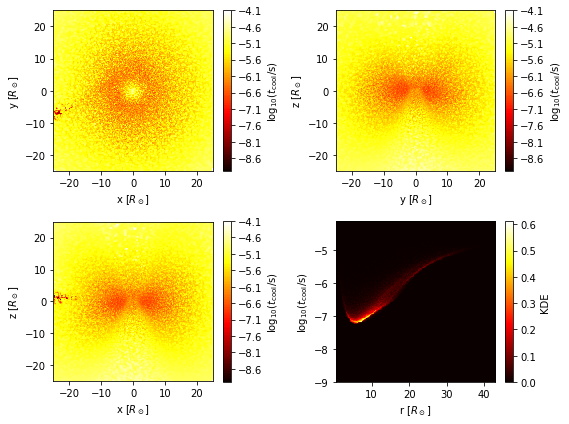

In [8]:
draw_prop('t_cool'+suffix+'.png',dump,10,'t_cool', 't_{\\rm cool}/{\\rm s}')

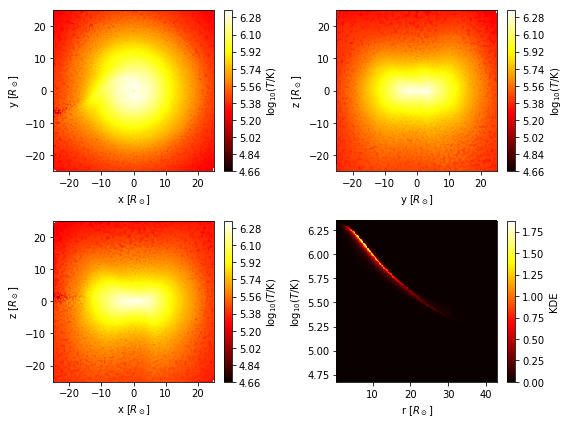

In [4]:
draw_prop('T'+suffix+'.png',dump,10,'Tem', 'T/{\\rm K}')

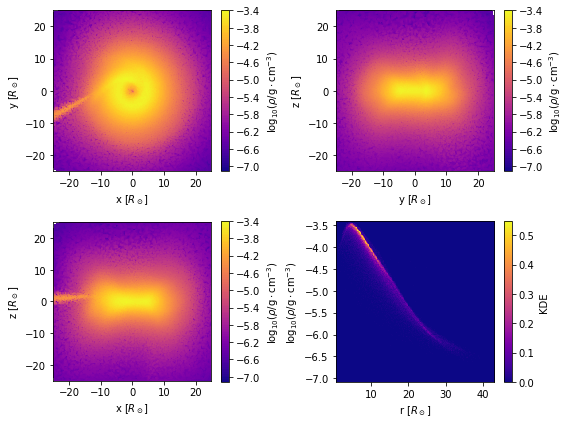

In [5]:
draw_prop('rho'+suffix+'.png',dump,10,'den', '\\rho/{\\rm g\cdot cm^{-3}}',cm.plasma)

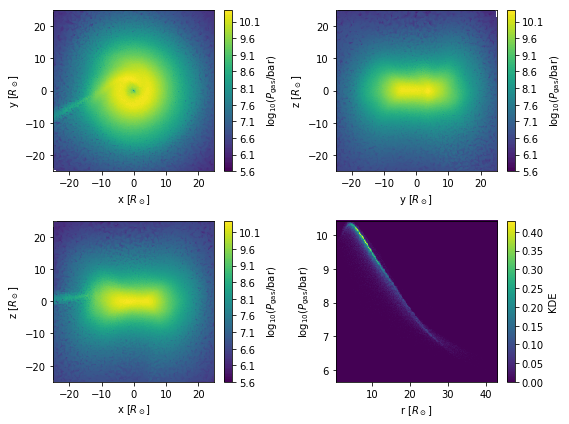

In [6]:
draw_prop('P_gas'+suffix+'.png',dump,10,'P_gas', 'P_{\\rm gas}/{\\rm bar}',cm.viridis)

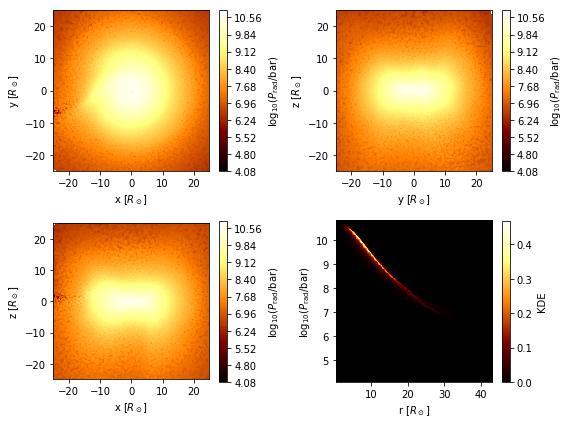

In [7]:
draw_prop('P_rad'+suffix+'.png',dump,10,'P_rad', 'P_{\\rm rad}/{\\rm bar}',cm.afmhot)